In [15]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from deap import base, creator, tools, algorithms
from optimize_portfolio import optimize_portfolio


In [16]:
"""
Data Setup
"""

# Load the dataset
asset_index = pd.read_excel("data/asset_index.xlsx")
trade_dt = pd.read_excel("data/ashare_trading_calender.xlsx")
asset_index = asset_index[asset_index['TRADE_DT'].isin(trade_dt['TRADE_DT'])]

unique_assets = asset_index['INDEX_CODE'].unique() # index_code list

In [17]:
"""
Clustering (Optional)
"""


'\nClustering (Optional)\n'

In [18]:
"""
GA Initialization
"""

# Objective Setup
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, -1.0)) # MAX: return, sharpe; MIN: volatility
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Individual Initialization (Clustering?)
def create_individual():
    individual = [random.randint(0, 1) for _ in range(len(unique_assets))]
    if sum(individual) == 0:  # If all zeros, randomly set one to 1
        individual[random.randint(0, len(unique_assets) - 1)] = 1
    return individual

# GA Initialization
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(unique_assets))
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [19]:
"""
Fitness Function with Regularization (Optional)
"""

# Fitness Function
def evaluate(individual):
    # Select assets based on the individual's binary vector
    selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]
    # Model output (new weights)
    new_weights, evaluation = optimize_portfolio('MVO', selected_assets, asset_index)

    # Expected Return, Sharpe Ratio, Volatility (Add regularization parameters? a+b+c=1?)
    expected_return, sharpe_ratio, volatility = evaluation

    return expected_return, sharpe_ratio, volatility

In [20]:
"""
Genetic Algorithm Setup
"""

# NSGA-II
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selNSGA2)

In [21]:
""""
Run Genetic Algorithm
"""

# Running the GA
def run_ga(pop_size, num_generations):
    pop = toolbox.population(n=pop_size)
    hof = tools.ParetoFront()
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=hof, verbose=True)

    return pop, hof, stats

# Example run
population, pareto_front, stats = run_ga(5, 10)  # 5 individuals, 10 generations

gen	nevals	avg                                           	std                                           	min                                           	max                                           
0  	5     	[1.39040893e-01 1.33020513e-03 3.65132863e+02]	[7.51548112e-02 1.93730248e-03 2.84513905e+02]	[3.39799500e-02 3.00818634e-04 7.92758615e+00]	[2.00000000e-01 5.20013491e-03 5.98367187e+02]
1  	5     	[1.39040893e-01 1.33020513e-03 3.65132863e+02]	[7.51548112e-02 1.93730248e-03 2.84513905e+02]	[3.39799500e-02 3.00818634e-04 7.92758615e+00]	[2.00000000e-01 5.20013491e-03 5.98367187e+02]
2  	4     	[1.31532124e-01 2.89617075e-03 3.63311430e+02]	[8.39189048e-02 5.06741914e-03 2.86204309e+02]	[0.02368067 0.00030156 0.28249337]            	[2.00000000e-01 1.30292262e-02 5.96905115e+02]
3  	4     	[1.32562052e-01 1.28083482e-03 3.66265893e+02]	[8.28892866e-02 2.10747174e-03 2.82660351e+02]	[2.03576663e-02 9.79258741e-06 4.08993788e+00]	[2.00000000e-01 5.48971511e-03 5.96905115e+02]
4  	3

In [22]:
# Population
print("Population")
print(population)

Population
[[0, 0, 0, 1, 1], [0, 1, 1, 0, 1], [1, 1, 0, 1, 1], [1, 0, 0, 1, 1], [0, 1, 1, 0, 0]]


In [23]:
# Pareto Front
# Retrieve Weights
def get_weights(individual):
    selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]
    new_weights, evaluation = optimize_portfolio('MVO', selected_assets, asset_index)
    return new_weights

# Retrieve and store weights
individual_weights = {str(ind): get_weights(ind) for ind in pareto_front}

print("Pareto Front")
for ind in pareto_front:
    print(f"Individual: {ind}, Weights: {individual_weights[str(ind)]}")

Pareto Front
Individual: [0, 1, 1, 1, 0], Weights: [ 9.07782083e-03 -2.27270637e-25  9.90922179e-01]
Individual: [1, 1, 1, 1, 0], Weights: [-4.01274040e-24  9.07782083e-03 -2.81253194e-24  9.90922179e-01]
Individual: [0, 1, 1, 1, 1], Weights: [-3.35484650e-23 -4.29614835e-23  9.88494552e-01  1.15054476e-02]
Individual: [1, 0, 0, 1, 1], Weights: [-4.52024921e-24  9.88494552e-01  1.15054476e-02]
Individual: [0, 0, 0, 1, 1], Weights: [0.98849455 0.01150545]
Individual: [1, 1, 1, 1, 1], Weights: [-2.67161786e-24 -1.94283923e-23 -1.88646040e-23  9.88494552e-01
  1.15054476e-02]
Individual: [1, 0, 1, 1, 1], Weights: [-6.44507903e-24 -4.04453490e-23  9.88494552e-01  1.15054476e-02]
Individual: [1, 1, 0, 1, 1], Weights: [9.98529063e-24 1.40083963e-23 9.88494552e-01 1.15054476e-02]
Individual: [0, 0, 1, 1, 1], Weights: [-2.26436397e-23  9.88494552e-01  1.15054476e-02]
Individual: [0, 1, 0, 1, 1], Weights: [-1.25068155e-23  9.88494552e-01  1.15054476e-02]
Individual: [0, 0, 0, 0, 1], Weights: [1

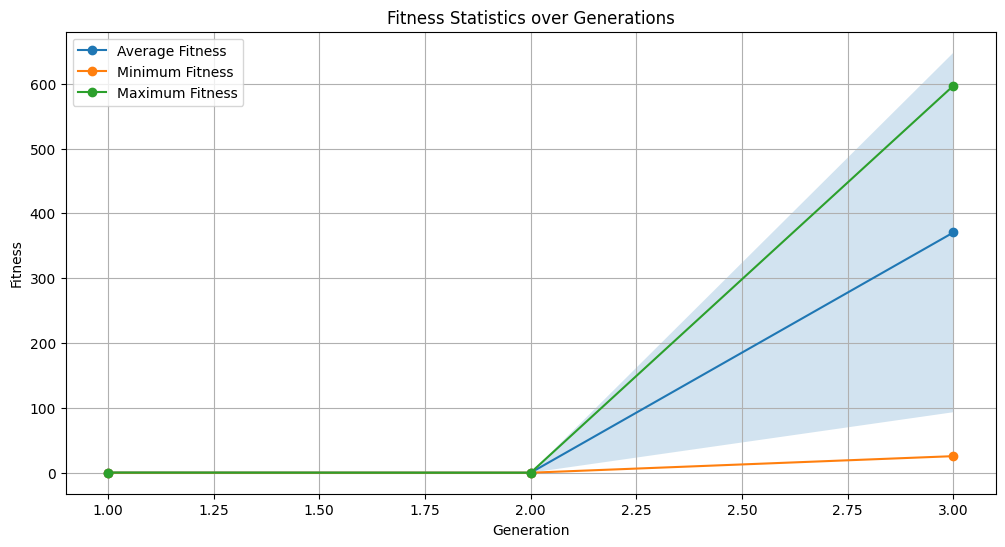

In [24]:
# Stats
all_stats = stats.compile(population) if stats else {}

# Extracting the statistics
avg_fitness = all_stats['avg']
std_fitness = all_stats['std']
min_fitness = all_stats['min']
max_fitness = all_stats['max']

# Number of generations
generations = list(range(1, len(avg_fitness) + 1))

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(generations, avg_fitness, label='Average Fitness', marker='o')
plt.plot(generations, min_fitness, label='Minimum Fitness', marker='o')
plt.plot(generations, max_fitness, label='Maximum Fitness', marker='o')

plt.fill_between(generations, avg_fitness - std_fitness, avg_fitness + std_fitness, alpha=0.2)

plt.title('Fitness Statistics over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()
